# Mapping mouse coronal snRNA-seq cell type to 10X Visium

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load cell type expression signatures programmes](#Loading_signatures)
* [Run cell2location](#cell2location)
* [Region clustering cell densities](#region_clustering)
* [Export regions for import to 10X Loupe Browser](#loupe)
* [Run diffusion maps](#diffmap)
* [Run factorisation to find groups of cell types with similar location](#factorisation)


### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
#import pycell2location.models as c2l

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_data/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')

In [3]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [4]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # for spatial mapping remove MT genes
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call 

Now let's look at QC: total number of counts and total number of genes per spot

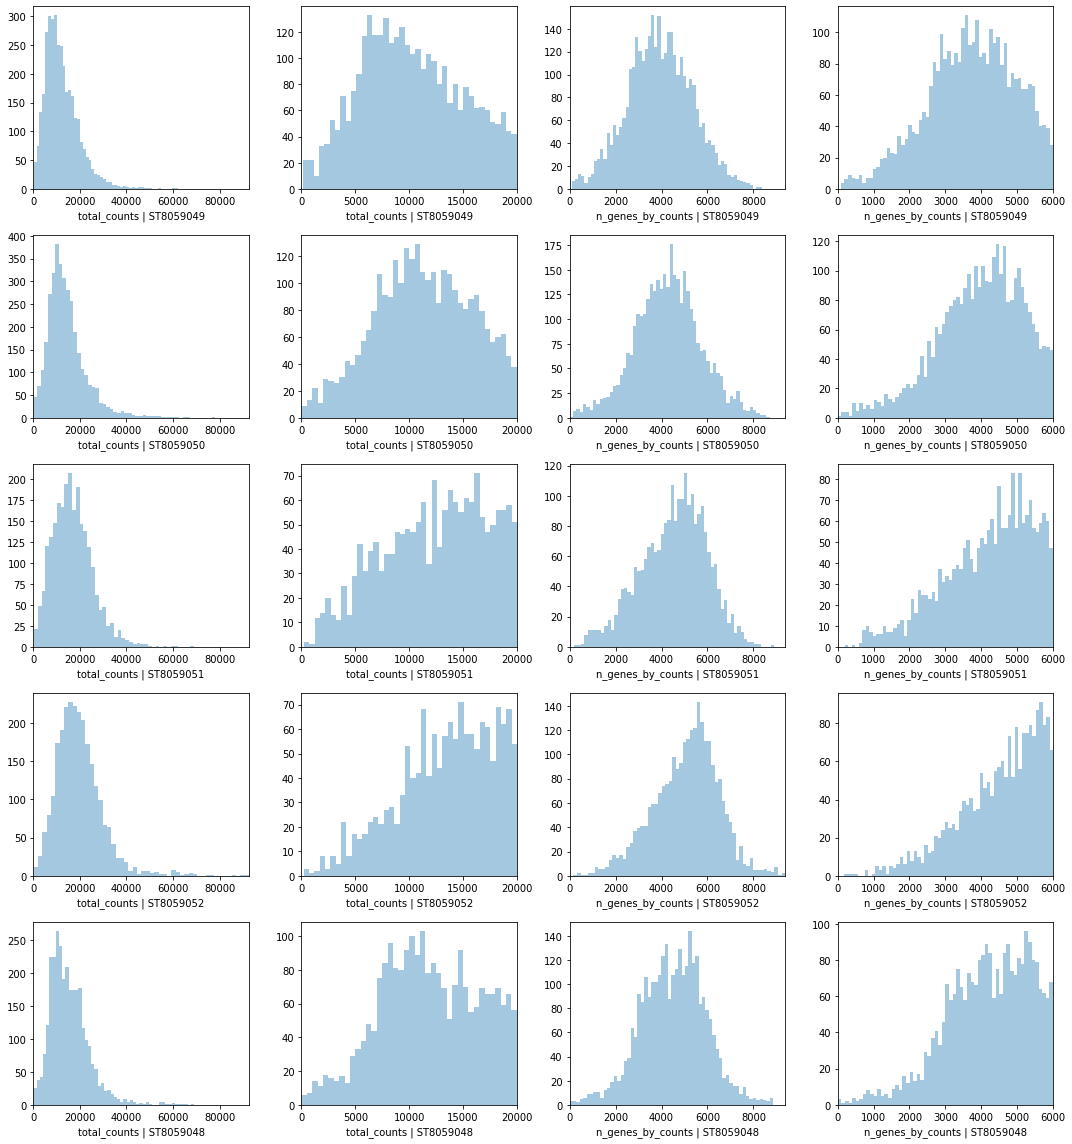

In [5]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


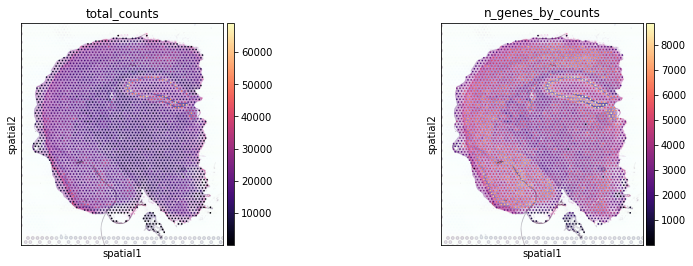

In [6]:
sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
              color=['total_counts', 'n_genes_by_counts'],
              gene_symbols='SYMBOL', size=0.8)

Here we show how to use scanpy to plot results over histology section using anndata object from one section, and 

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'image_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'position' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical


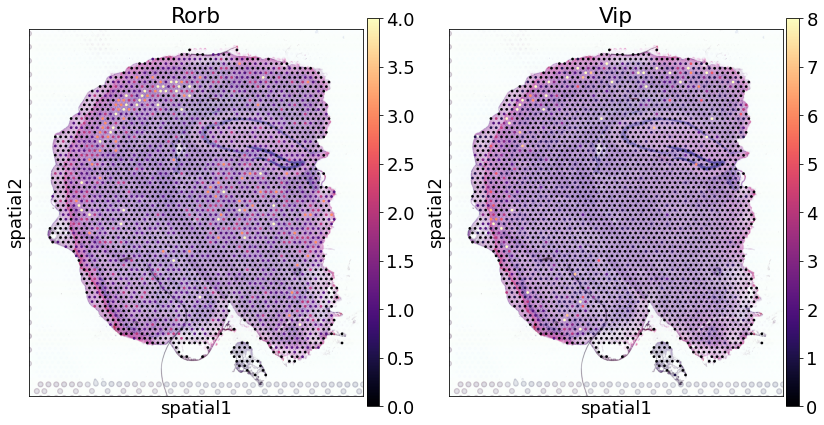

In [7]:
rcParams["axes.facecolor"] = "black"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(adata[adata.obs["sample"]==adata.obs["sample"].unique()[0], :], 
              color=["Rorb", "Vip"], img_key='hires',
              vmin=0, cmap='magma', vmax='p99.0',
              gene_symbols='SYMBOL', size=0.8
             )

In [8]:
adata.raw = adata

### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [9]:
reg_mod_name = 'RegressionNBV2Torch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

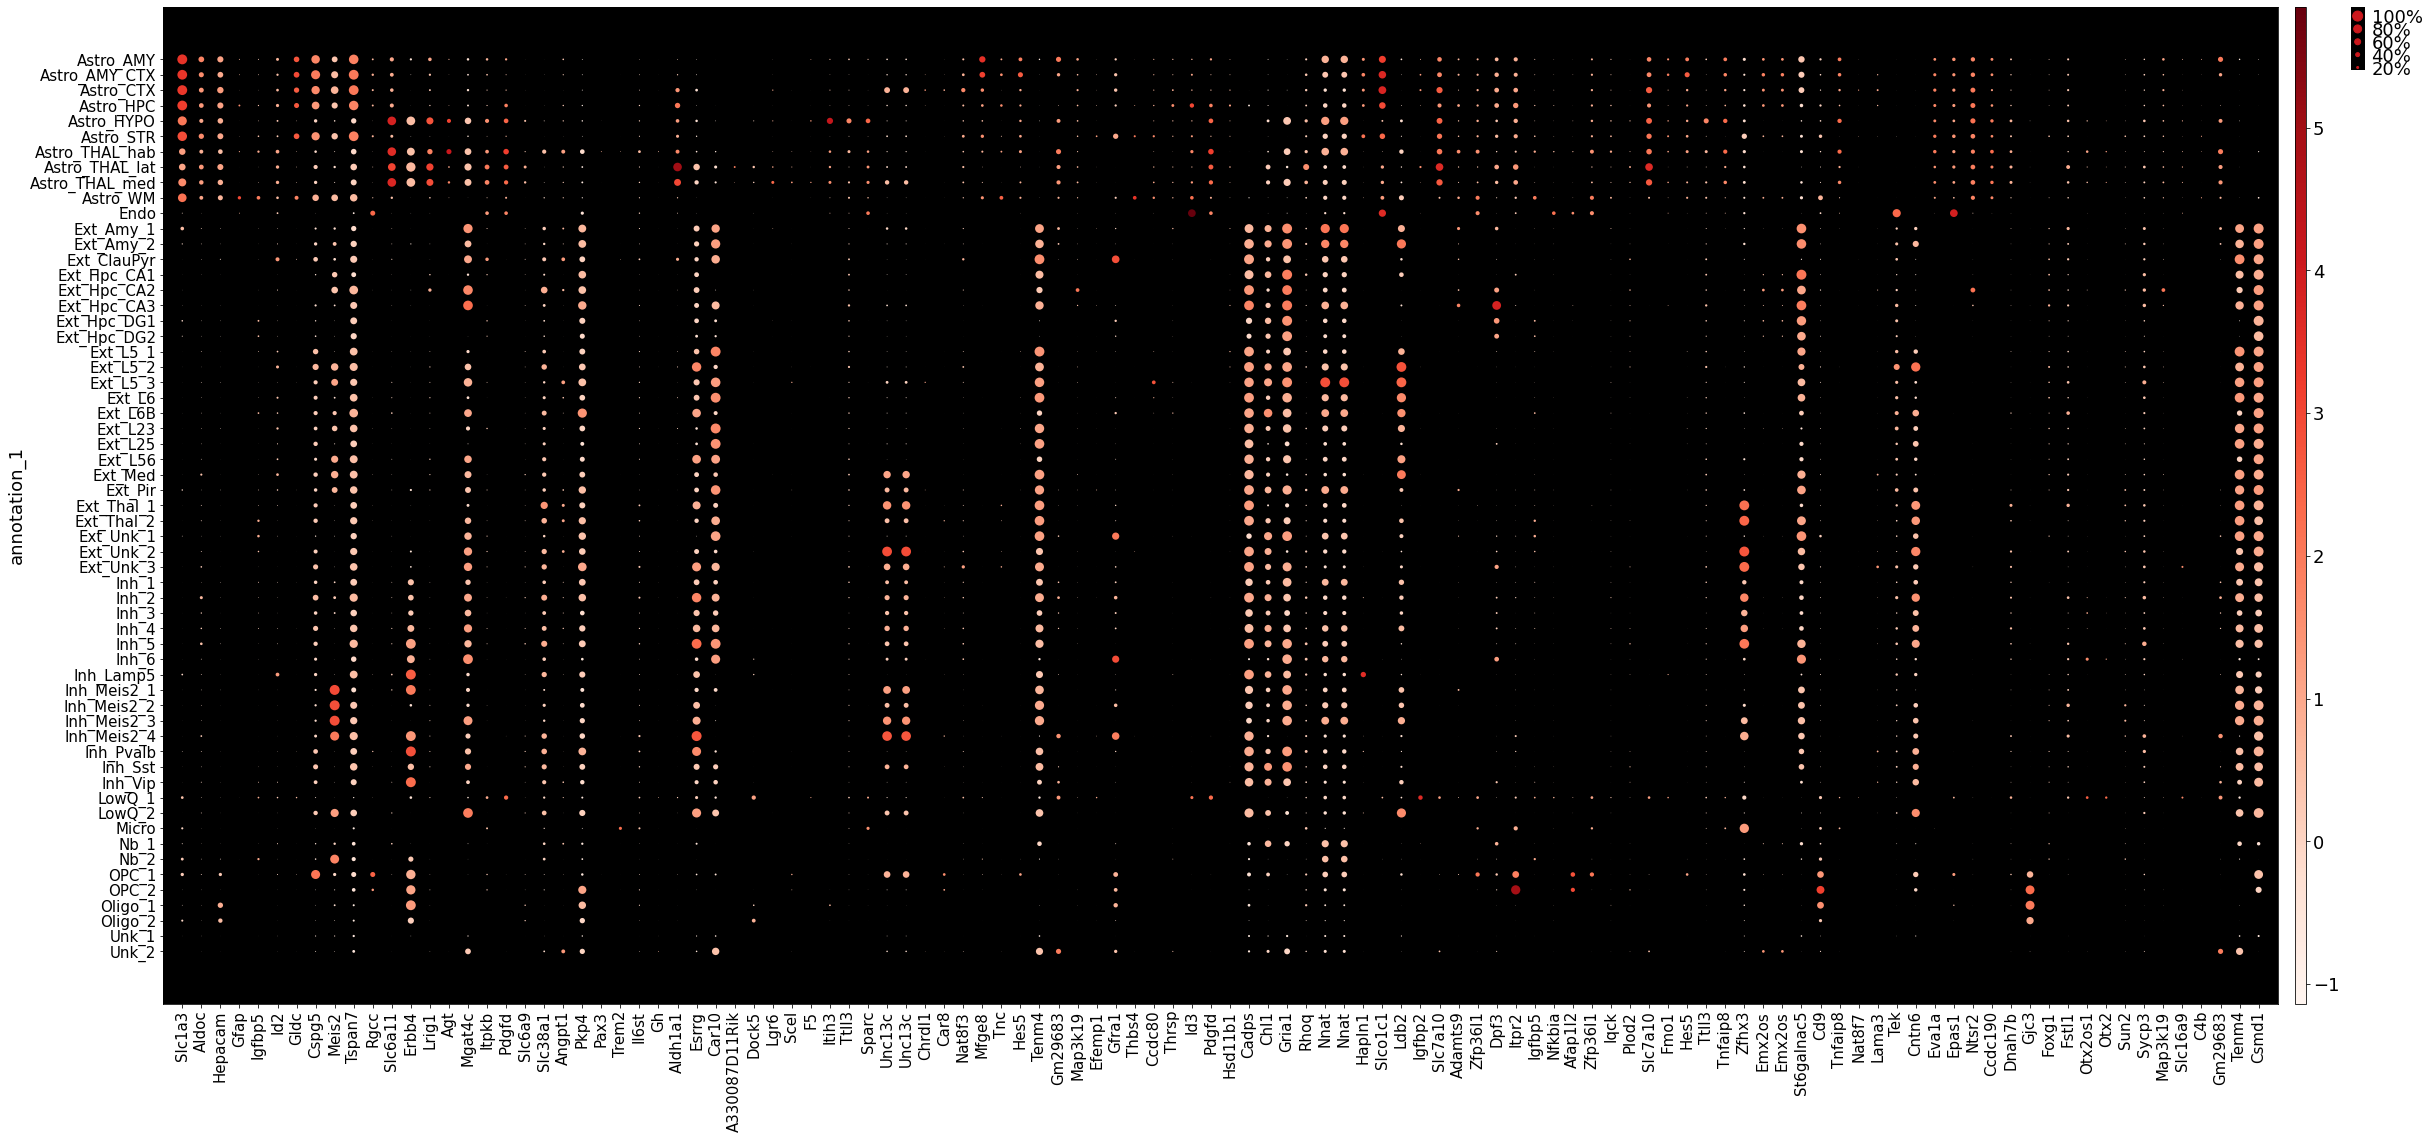

In [10]:
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{reg_path}marker_plots/'

gene_list = pd.read_csv(f'{reg_path}figures/Subtype_markers.csv', header=0)['Genes']
with matplotlib.rc_context({'axes.facecolor':  'black'}):
    sc.pl.dotplot(adata_snrna_raw, gene_list, groupby='annotation_1', 
                  gene_symbols='SYMBOL', use_raw=False, 
                  #save=f'selected_panel.pdf', 
                  show=True);
sc.settings.figdir = sc_figpath

In [11]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, [f'mean_cov_effect_annotation_1_{i}' for i in adata_snrna_raw.obs['annotation_1'].unique()]]
from re import sub
inf_aver.columns = [sub(f'mean_cov_effect_annotation_1_{i}', '', i) for i in adata_snrna_raw.obs['annotation_1'].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [12]:
inf_aver

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,LowQ_2,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1,Unk_2
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,0.006652,0.013381,0.009672,0.010551,0.016396,4.362995e-09,3.918688e-03,0.012995,0.020950,0.053045,...,6.475789,0.009182,2.363688,0.569750,2.202130,0.773202,2.177433,0.885846,1.399780,1.228170
ENSMUSG00000089699,0.001501,0.001095,0.002055,0.000696,0.003748,1.116136e-02,5.403521e-09,0.001581,0.001147,0.009992,...,1.259508,0.000859,0.512654,0.132410,0.383906,0.165249,0.423312,0.161883,0.227617,0.174571
ENSMUSG00000033845,0.114207,0.054338,0.085309,0.059021,0.066498,2.202430e-02,6.959011e-02,0.064746,0.104896,0.060093,...,0.214894,0.039218,0.108909,0.095944,0.084072,0.094551,0.077346,0.054940,0.041642,0.113457
ENSMUSG00000033813,0.088453,0.097077,0.129549,0.093324,0.080831,1.292675e-01,6.526587e-02,0.057145,0.082130,0.081030,...,0.194244,0.063650,0.084617,0.121712,0.108767,0.181124,0.140567,0.066971,0.013325,0.091371
ENSMUSG00000002459,3.596771,4.084791,4.167773,3.955367,1.140844,3.839240e+00,1.391272e+00,1.597041,1.308752,4.189671,...,0.062062,0.004818,0.133042,1.217572,0.614752,0.097037,0.037659,0.004848,0.107176,0.120861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064370,0.154425,0.135329,0.106853,0.123680,0.061573,8.559838e-02,2.359829e-01,0.087570,0.072310,0.312812,...,0.184294,0.044913,0.130184,0.070209,0.112571,0.116551,0.049836,0.060489,0.038373,0.070576
ENSMUSG00000051412,0.042569,0.033413,0.051312,0.052405,0.043928,5.851342e-02,5.412691e-09,0.033294,0.038056,0.069674,...,0.083921,0.012877,0.063890,0.057759,0.083447,0.102482,0.096118,0.067913,0.023124,0.097860
ENSMUSG00000079834,0.233599,0.240260,0.301797,0.227757,0.257566,4.087606e-01,1.732663e-01,0.321039,0.316733,0.072512,...,0.189396,0.059993,0.077447,0.020228,0.286553,0.304142,0.255407,0.111864,0.034153,0.088070


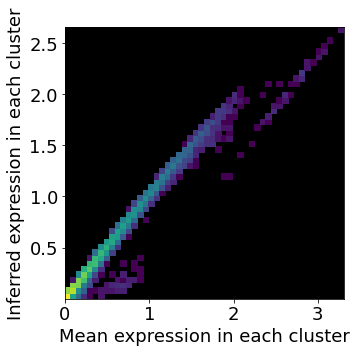

In [13]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

## Examine the number of genes specific to each cluster, within neurones and astrocytes

In [14]:
# selecting most informative genes based on specificity
selection_specificity = 0.05

# normalise expression signatures:
cell_state_df_norm = (inf_aver.T / inf_aver.sum(1)).T
# apply cut off:
cell_state_df_norm = (cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
pd.set_option('display.max_rows', int(inf_aver.shape[1]))
cell_state_df_norm.sum(0), (cell_state_df_norm.sum(1) > 0).sum(0), inf_aver.shape[0]

(Astro_AMY          245
 Astro_AMY_CTX      272
 Astro_CTX          274
 Astro_HPC          262
 Astro_HYPO         204
 Astro_STR          230
 Astro_THAL_hab     206
 Astro_THAL_lat     262
 Astro_THAL_med     228
 Astro_WM           162
 Endo               316
 Ext_Amy_1          363
 Ext_Amy_2          362
 Ext_ClauPyr        561
 Ext_Hpc_CA1        395
 Ext_Hpc_CA2        996
 Ext_Hpc_CA3        924
 Ext_Hpc_DG1        231
 Ext_Hpc_DG2        118
 Ext_L23            491
 Ext_L25            223
 Ext_L56            233
 Ext_L5_1           492
 Ext_L5_2          1268
 Ext_L5_3           397
 Ext_L6             368
 Ext_L6B            503
 Ext_Med            181
 Ext_Pir            521
 Ext_Thal_1         903
 Ext_Thal_2         568
 Ext_Unk_1          236
 Ext_Unk_2          203
 Ext_Unk_3          456
 Inh_1              204
 Inh_2              436
 Inh_3               74
 Inh_4              287
 Inh_5              452
 Inh_6              319
 Inh_Lamp5          258
 Inh_Meis2_1    

In [15]:
# selecting most informative genes based on specificity
selection_specificity = 0.2

astro_inf_aver = inf_aver.loc[:, ['Astro' in i for i in inf_aver.columns]]
astro_inf_aver = astro_inf_aver.loc[cell_state_df_norm[astro_inf_aver.columns].sum(1) > 0, :]

# normalise expression signatures:
astro_cell_state_df_norm = (astro_inf_aver.T / astro_inf_aver.sum(1)).T
# apply cut off:
astro_cell_state_df_norm = (astro_cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
pd.set_option('display.max_rows', int(astro_inf_aver.shape[1]))
astro_cell_state_df_norm.sum(0), (astro_cell_state_df_norm.sum(1) > 0).sum(0), astro_inf_aver.shape[0]

(Astro_AMY          6
 Astro_AMY_CTX     30
 Astro_CTX         28
 Astro_HPC         16
 Astro_HYPO        35
 Astro_STR         23
 Astro_THAL_hab    34
 Astro_THAL_lat    45
 Astro_THAL_med    30
 Astro_WM          44
 dtype: int64,
 206,
 551)

In [16]:
# selecting most informative genes based on specificity
selection_specificity = 0.2

ext_inf_aver = inf_aver.loc[:, ['Ext' in i for i in inf_aver.columns]]
ext_inf_aver = ext_inf_aver.loc[cell_state_df_norm[ext_inf_aver.columns].sum(1) > 0, :]

# normalise expression signatures:
ext_cell_state_df_norm = (ext_inf_aver.T / ext_inf_aver.sum(1)).T
# apply cut off:
ext_cell_state_df_norm = (ext_cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
pd.set_option('display.max_rows', int(ext_inf_aver.shape[1]))
ext_cell_state_df_norm.sum(0), (ext_cell_state_df_norm.sum(1) > 0).sum(0), ext_inf_aver.shape[0]

(Ext_Amy_1       74
 Ext_Amy_2       46
 Ext_ClauPyr     81
 Ext_Hpc_CA1     44
 Ext_Hpc_CA2    108
 Ext_Hpc_CA3     84
 Ext_Hpc_DG1     31
 Ext_Hpc_DG2     15
 Ext_L23         33
 Ext_L25         26
 Ext_L56         25
 Ext_L5_1        34
 Ext_L5_2        78
 Ext_L5_3        54
 Ext_L6          18
 Ext_L6B         70
 Ext_Med         17
 Ext_Pir         59
 Ext_Thal_1     226
 Ext_Thal_2     137
 Ext_Unk_1       51
 Ext_Unk_2       78
 Ext_Unk_3      122
 dtype: int64,
 1207,
 4667)

In [17]:
# selecting most informative genes based on specificity
selection_specificity = 0.2

inh_inf_aver = inf_aver.loc[:, ['Inh' in i for i in inf_aver.columns]]
inh_inf_aver = inh_inf_aver.loc[cell_state_df_norm[inh_inf_aver.columns].sum(1) > 0, :]

# normalise expression signatures:
inh_cell_state_df_norm = (inh_inf_aver.T / inh_inf_aver.sum(1)).T
# apply cut off:
inh_cell_state_df_norm = (inh_cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
pd.set_option('display.max_rows', int(inh_inf_aver.shape[1]))
inh_cell_state_df_norm.sum(0), (inh_cell_state_df_norm.sum(1) > 0).sum(0), inh_inf_aver.shape[0]

(Inh_1           93
 Inh_2           92
 Inh_3           24
 Inh_4           92
 Inh_5          159
 Inh_6          208
 Inh_Lamp5      151
 Inh_Meis2_1     47
 Inh_Meis2_2    179
 Inh_Meis2_3    172
 Inh_Meis2_4    208
 Inh_Pvalb      165
 Inh_Sst        106
 Inh_Vip         71
 dtype: int64,
 1322,
 2024)

Modules and their versions used for this analysis

In [18]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.0
ipykernel._version 5.3.0
json 2.0.9
re 2.2.1
IPython 7.15.0
IPython.core.release 7.15.0
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.15.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.2
argparse 1.1
pygments 2.6.1
pexpect 4.8.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.5
wcwidth 0.2.4
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.4.3
pkg_resources._vendor.packaging 20.4
pkg_resources._vendor.packaging.__about__ 20.4
pkg_resources.extern.packaging 20.4
pkg_resources._vendor.pyparsing 2.2.1
pkg_resources.extern.pyparsing 2.2.1
jedi 0.17.1
parso 0.7.0
urllib.request 3.7
jupyter_client 6.1.3
jupyter_client._version 6.1.3
zmq 19.0.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.1
zmq.sugar.constants 40302
zmq.sugar.version 19.0.1
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.6
_curses b'2.2'
dat